Below is the study of classification problem using Multilinear regression, Decision tree, and Random Forest. The data consists of 40 features that caracterize the texture of a surface. All the features are numerical value. There are certain types of texture. The type of texture is assumed to be characterized by the features given.

The problem is to explain the texture type based on the input features.

In [138]:
import pandas as pd
import numpy as np
from sklearn import tree, ensemble
from matplotlib import pyplot as plt

In [139]:
"""Variables in the class objects:

   original_attribute   --   total instances of attributes in the dataset
   original_target      --   total targets in the dataset
   train_attribute      --   training subset of original_attribute
   train_target         --   training subset of original_target
   test_attribute       --   test subset of original_attribute
   test_target          --   test subset of original_target
   total_count          --   total number of samples in the dataset
   train_count          --   number of training samples
   test_count           --   number of test samples
   univariate_desc      --   stores description from univariate analysis of the attributes
"""
class Data:
  def __init__(self):
    self.original_attribute = pd.DataFrame()
    self.original_target = pd.DataFrame()
    self.train_attribute = pd.DataFrame()
    self.train_target = pd.DataFrame()
    self.test_attribute = pd.DataFrame()
    self.test_target = pd.DataFrame()
    self.total_count = 0
    self.train_count = 0
    self.test_count = 0

  #sets the dataset from the given file (features and target data are taken seperately)
  def setData(self, file_name, target_name):
    self.original_attribute = pd.read_csv(file_name)
    self.original_target = pd.DataFrame(self.original_attribute.loc[:, target_name])
    self.total_count = len(self.original_attribute)
    self.original_attribute.drop(target_name, axis=1, inplace=True)
  #sets the training set if training set is provoded seperately
  def setTrain(self, X, Y):
    train_attribute = X
    train_target = Y
  #sets the test set if the test set is provided seperately
  def setTest(self, X, Y):
    test_attribute = X
    test_target = Y
  #splits the original dataset into training and test samples randomly into given proportion
  def setTrainTest(self, test_proportion=0.2):
    test_size = int(test_proportion*self.total_count)
    #seed the generator so that same permutation is generated everytime dataset is loaded
    rng = np.random.default_rng(seed=100)
    #add the target dataset into the attributes dataset for easy splitting
    self.original_attribute.loc[:, 'target'] = self.original_target
    #get a randomly shuffled indices for the original dataset
    shuffled_indices = rng.permutation(self.total_count)

    #select a total of (total_count-test_size) training samples from the dataset using shuffled_indices
    self.train_attribute = self.original_attribute.iloc[shuffled_indices[test_size:]]
    self.test_attribute = self.original_attribute.iloc[shuffled_indices[:test_size]]
    #select a total of test_size test samples from the dataset using shuffled_indices
    self.train_target = self.original_target.iloc[shuffled_indices[test_size:]]
    self.test_target = self.original_target.iloc[shuffled_indices[:test_size]]
    #set the training and test sample sizes
    self.train_count = self.train_attribute.shape[0]
    self.test_count = self.test_attribute.shape[0]

    #remove the target column from the original dataset, training, and test samples
    self.original_attribute.drop('target', axis=1, inplace=True)
    self.train_attribute.drop('target', axis=1, inplace=True)
    self.test_attribute.drop('target', axis=1, inplace=True)

    #the indices are the shuffled indices. Reset the indices to start from zero
    self.train_attribute.reset_index(drop=True, inplace=True)
    self.test_attribute.reset_index(drop=True, inplace=True)
    self.train_target.reset_index(drop=True, inplace=True)
    self.test_target.reset_index(drop=True, inplace=True)

  #normalise the dataset to zero mean and unit variance
  def normalize(self, X):
    size = len(X)
    num_attributes = X.shape[1]
    mean = X.mean()
    std = X.std()
    return (X - mean)/std

  #perform Univariate Analysis using pandas describe() function
  def univariateAnalysis(self):
    self.univariate_desc = self.original_attribute.describe()
    #add interquartile range to the description data
    self.univariate_desc.loc['IQR', :] = self.univariate_desc.loc['75%', :] - self.univariate_desc.loc['25%', :]

  #Graphical Visualization
  #hist_num - number of histograms to plot
  #cols - number of columns in the plot table
  #x_dimension, y_dimension - linear dimension of the plot table
  def plotHistograms(self, dataset, hist_num=6, cols=6, x_dimension=10, y_dimension=5):
    plot_labels = dataset.columns.to_numpy()[:hist_num]#np.append(dataset.columns.to_numpy()[0:hist_num], dataset.columns.to_numpy()[-1])
    rows = int(np.ceil(len(plot_labels)/cols))
    plots, ax = plt.subplots(rows, cols, figsize=(x_dimension, y_dimension), squeeze=False)
    for i, x in enumerate(plot_labels):
      """min = description[x]['min']
      max = description[x]['max']"""
      min = dataset[x].min()
      max = dataset[x].max()
      row = int(i/cols)
      col = i%cols
      ax[row, col].hist(dataset.loc[:, x].to_numpy(), bins=30, range=(min, max), color='#1063fd')
      ax[row, col].set_title(x)
      ax[row,0].set_ylabel('frequency')
    plots.tight_layout()
    plt.show()

In [140]:
"""Variables in the class objects:

   eigensystem         --   eigenvector matrix with their eigenvalues
   covariance_matrix   --   covariance matrix of the attributes (defined if asked)
   num_components      --   number of components to be kept
"""
class PCA:
  def __init__(self):
    pass
  #compute the principle components and their eigenvalues
  def principleDirections(self, attributes, covariance = False, centered = True):
    """compute average of each attributes
    average = pd.DataFrame(attributes.sum(axis=0) / attributes.shape[0]).T"""

    #shift the average of the attributes to zero if the data is not centered
    if not centered:
      attributes = attributes - attributes.mean()#average.iloc[0]

    #covariance matrix of the attributes. More accurately, covariance matrix times the number of attributes minus one
    covariance_matrix = np.dot(attributes.T, attributes)

    #calculate the eigenvectors and eigenvalues of the covariance matrix
    #kth column of eigenvector correspond to kth eigenvalue element
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    #store eigenvectors in rows
    self.eigensystem = pd.DataFrame(eigenvectors.T)
    self.eigensystem.loc[:, 'eigenvalue'] = eigenvalues
    #eigenvalues are not necessarily returned sorted
    self.eigensystem.sort_values('eigenvalue', ascending=False, inplace=True)

    #stores the covariance matrix if asked
    if covariance:
      self.covariance_matrix = covariance_matrix

  #set the number of components to be kept
  def setNumComponents(self, num_components):
    self.num_components = num_components

  #transforms the original attributes to principal direction coordinate and reduces the dimension to num_components
  def transform(self, attributes):
    #get the first num_components principle components
    principle_components = self.eigensystem.iloc[:self.num_components].copy()
    #eigenvalue is not needed
    principle_components.drop('eigenvalue', axis=1, inplace=True)
    #transform the attributes to principle components
    reduced_input = pd.DataFrame(np.dot(attributes, principle_components.T))
    #rename the columns in the decreasing order of their significance
    reduced_input.columns = [('PC'+str(i)) for i in range(1, self.num_components+1)]
    return reduced_input

  #calculates the variance and cumulative variance
  def varianceAnalysis(self):
    sum_eigenvalues = self.eigensystem['eigenvalue'].sum()
    explained_variance = self.eigensystem['eigenvalue'] / sum_eigenvalues
    cumulative_explained_variance = explained_variance.cumsum()
    return explained_variance, cumulative_explained_variance

In [141]:
"""Variables in the class objects:

   kfold           --   number of folds
   size            --   total number of samples
   split_indices   --   starting indices of each Fold
   split_sizes     --   sizes of each Fold
"""
class crossFoldValidation:
  def __init__(self, kfold=5):
    self.kfold = kfold
  #sets the number of folds
  def setFolds(self, kfold):
    self.kfold = kfold
  #sets the starting indices and corresponding sizes of each Fold
  def crossFoldSplit(self, X, Y):
    self.size = len(X)
    #array length of each fold (ignoring the last Fold's length which might have some residual length)
    split_size = int(self.size/self.kfold)
    #get the starting indices of each Fold
    self.split_indices = np.array([x for x in range(0, split_size*self.kfold, split_size)])
    #set the sizes of each fold but the last Fold
    self.split_sizes = np.array([self.split_indices[i]-self.split_indices[i-1] for i in range(1,len(self.split_indices))])
    #set the size of the last Fold
    self.split_sizes = np.append(self.split_sizes, self.size - self.split_indices[-1])
  def getKFoldTrain(self, X, Y, kfold=1):
    #create an array of indices containing all indices but the indices of kfold Fold
    indices = np.array([x for x in range(self.size) if x not in range(self.split_indices[kfold-1], self.split_indices[kfold-1]+self.split_sizes[kfold-1])])
    return X.iloc[indices], Y.iloc[indices]
  def getKFoldTest(self, X, Y, kfold=1):
    indices = np.array([x for x in range(self.split_indices[kfold-1], self.split_indices[kfold-1]+self.split_sizes[kfold-1])])
    return X.iloc[indices], Y.iloc[indices]

In [142]:
#takes training data and calculates linear regression parameters: weights and bias.
#It takes features as (N, n) matrix, and target as (N, 1) matrix, where N is the training size and n is the feature size.
#The output is a weight array of dimension (1, n) and a bias as float.
"""variables in the class objects"""
"""dimension
   weights
   bias"""
class linearRegression(crossFoldValidation):
  def __init__(self):
    pass
  def fit(self, X, Y, threshold=0.001, learning_rate=0.0001):
    self.dimension = X.shape[1]
    N = len(X)
    attr = X.copy()
    attr.loc[:, '1s'] = np.ones(N)
    param = np.linalg.lstsq(attr, Y, rcond=None)
    attr.drop('1s', axis=1, inplace=True)
    self.weights = param[0][:-1].reshape((1, self.dimension))
    self.bias = param[0][-1]
  def modelAccuracy(self, X, Y, vif_score=False):
    attr = X.copy()
    Residual_error = pd.DataFrame()
    Residual_error = Y.copy()
    Residual_error.columns = ['observed']
    Residual_error.loc[:, 'prediction'] = np.dot(attr, self.weights.T) + self.bias
    Residual_error.loc[:, 'residual'] = Residual_error.loc[:, 'prediction'] - Residual_error.loc[:, 'observed']
    #calculate the squared sums from variances
    prediction_accuracy = Residual_error.var()
    prediction_accuracy *= len(attr)-1
    #rename the column names
    prediction_accuracy.rename(index={'observed': 'SSTO', 'residual': 'SSE', 'prediction': 'SSR'}, inplace=True)
    #calculate coefficient of determination
    prediction_accuracy.loc['r2'] = prediction_accuracy.loc['SSR']/prediction_accuracy.loc['SSTO']

    if vif_score:
      from statsmodels.stats.outliers_influence import variance_inflation_factor
      from statsmodels.tools.tools import add_constant
      attr = add_constant(attr)
      #calculate the VIF score for the prediction
      VIF = pd.Series([variance_inflation_factor(attr.values, i) for i in range(attr.shape[1])], index=attr.columns)
      return prediction_accuracy, VIF
    return prediction_accuracy

  def crossValidation(self, attribute_dataset, target_dataset):
    ##average_train_accuracy = pd.Series({'SSTO': 0, 'SSR': 0, 'SSE': 0, 'r2': 0})
    ##average_test_accuracy = pd.Series({'SSTO': 0, 'SSR': 0, 'SSE': 0, 'r2': 0})

    train_accuracy = pd.DataFrame()
    test_accuracy = pd.DataFrame()

    for i in range(1, self.kfold+1):
      train_attribute, train_target = self.getKFoldTrain(attribute_dataset, target_dataset, i)

      self.fit(train_attribute, train_target)
      prediction_accuracy = LR.modelAccuracy(train_attribute, train_target)
      ##average_train_accuracy = ((average_train_accuracy)*(i-1) + prediction_accuracy) / i
      train_accuracy.loc[:, 'Fold '+str(i)] = prediction_accuracy

      test_attribute, test_target = self.getKFoldTest(attribute_dataset, target_dataset, i)

      self.fit(test_attribute, test_target)
      prediction_accuracy = LR.modelAccuracy(test_attribute, test_target)
      ##average_test_accuracy = ((average_test_accuracy)*(i-1) + prediction_accuracy) / i
      test_accuracy.loc[:, 'Fold '+str(i)] = prediction_accuracy
    return train_accuracy.T, test_accuracy.T

In [143]:
Texture = Data()
Texture.setData("Texture.csv", "A41")

In [144]:
#default test-train ratio is 0.2
Texture.setTrainTest()

<ipython-input-139-f18391da07fc>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_attribute.drop('target', axis=1, inplace=True)
<ipython-input-139-f18391da07fc>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_attribute.drop('target', axis=1, inplace=True)


In [145]:
print("Training sample contains " + str(Texture.train_count) + " samples")
print("Test sample contains " + str(Texture.test_count) + " samples")

Training sample contains 4400 samples
Test sample contains 1100 samples


# Exploratory Data Analysis

In [146]:
Texture.univariateAnalysis()

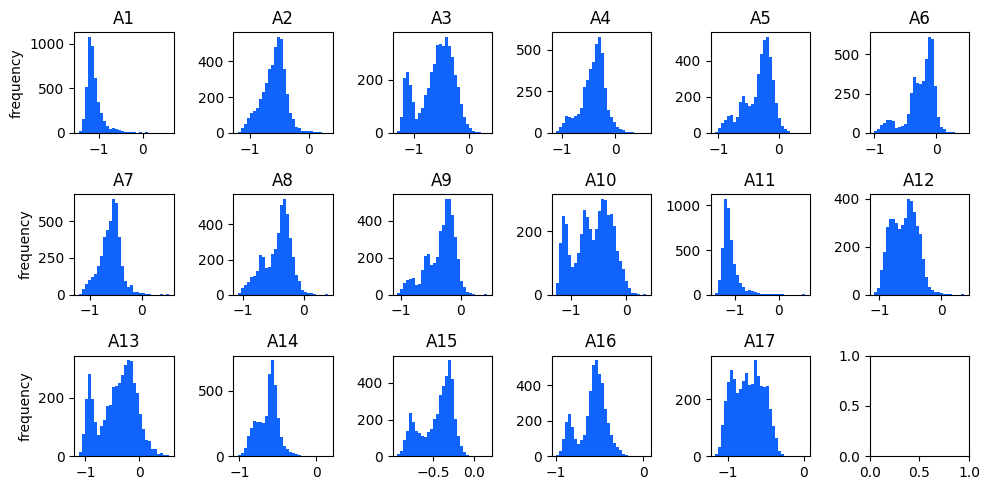

In [147]:
Texture.plotHistograms(Texture.train_attribute, hist_num=17, cols=6)

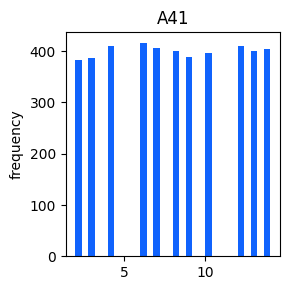

In [148]:
Texture.plotHistograms(Texture.train_target, hist_num=1, cols=1, x_dimension=3, y_dimension=3)

1.   Some attributes are skewed.
2.   The data is almost balanced as each target values appear with nearly same frequency.

Outliers need to be removed.

In [149]:
##Texture.train_attribute.loc[:, 'A41'] = Texture.train_target
Q3 = Texture.univariate_desc.loc['75%', :]
IQR = Texture.univariate_desc.loc['IQR', :]

for x in Texture.train_attribute:
  #retain only those that are not outlier
  Texture.train_attribute = Texture.train_attribute[Texture.train_attribute[x] < Q3[x] + 3*IQR[x]]

#reset the row indices
##Texture.train_attribute.reset_index(drop=True, inplace=True)
Texture.train_target = Texture.train_target.iloc[Texture.train_attribute.index]
Texture.train_attribute.reset_index(drop=True, inplace=True)
Texture.train_target.reset_index(drop=True, inplace=True)

In [150]:
print("Initial training sample contained " + str(Texture.train_count) + " samples")
print(str(Texture.train_count - Texture.train_attribute.shape[0]) + " outliers are removed")
print("Final training sample contains " + str(Texture.train_attribute.shape[0]) + " samples")

Initial training sample contained 4400 samples
96 outliers are removed
Final training sample contains 4304 samples


In [151]:
Texture.train_count = Texture.train_attribute.shape[0]

By removing outliers $(>Q3 + 3\times IQR)$, 96 samples are removed.

In [ ]:
Texture.train_attribute.describe()

We see that the range of data is almost similar so we do not need to normalize the data using the standard deviations.

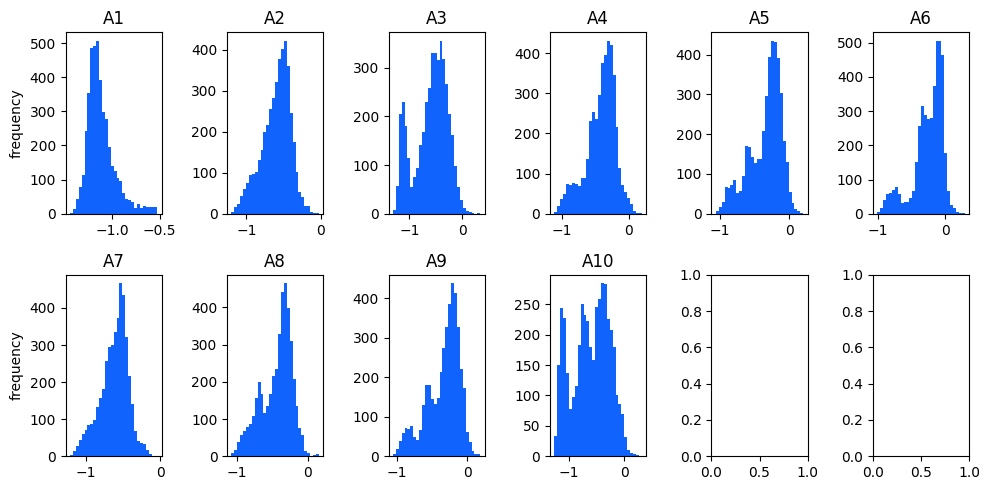

In [152]:
Texture.plotHistograms(Texture.train_attribute, hist_num=10, cols=6)

In [153]:
spearman_corr_matrix = Texture.train_attribute.corr(method='spearman')
spearman_corr_matrix

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40
A1,1.000000,0.513042,0.291111,0.500410,0.373534,0.377109,0.540281,0.401258,0.394794,0.311581,...,1.000000,0.636120,0.482370,0.633437,0.499148,0.486375,0.573772,0.464865,0.417590,0.396160
A2,0.513042,1.000000,0.761453,0.942740,0.864556,0.778130,0.946188,0.883734,0.841518,0.698939,...,0.513042,0.820074,0.632897,0.810330,0.689845,0.548426,0.841584,0.728449,0.724557,0.692644
A3,0.291111,0.761453,1.000000,0.755024,0.851146,0.751636,0.781938,0.924643,0.877951,0.962102,...,0.291111,0.772328,0.756138,0.753173,0.790440,0.688569,0.809425,0.814075,0.833709,0.805063
A4,0.500410,0.942740,0.755024,1.000000,0.925888,0.887580,0.936713,0.895003,0.915051,0.713870,...,0.500410,0.825810,0.748469,0.820824,0.788539,0.667625,0.870418,0.818697,0.813490,0.795663
A5,0.373534,0.864556,0.851146,0.925888,1.000000,0.943212,0.845939,0.942972,0.947778,0.789039,...,0.373534,0.750228,0.807748,0.729729,0.826981,0.733210,0.823576,0.858123,0.867495,0.863656
A6,0.377109,0.778130,0.751636,0.887580,0.943212,1.000000,0.772724,0.858292,0.927642,0.715198,...,0.377109,0.676199,0.802902,0.662862,0.815132,0.752582,0.761157,0.833452,0.839053,0.844898
A7,0.540281,0.946188,0.781938,0.936713,0.845939,0.772724,1.000000,0.906037,0.875072,0.771393,...,0.540281,0.886459,0.687440,0.872022,0.749954,0.610442,0.868693,0.772835,0.765721,0.719850
A8,0.401258,0.883734,0.924643,0.895003,0.942972,0.858292,0.906037,1.000000,0.956709,0.894078,...,0.401258,0.834047,0.793438,0.812708,0.833936,0.719660,0.866981,0.860549,0.865904,0.837640
A9,0.394794,0.841518,0.877951,0.915051,0.947778,0.927642,0.875072,0.956709,1.000000,0.876490,...,0.394794,0.803417,0.845961,0.782964,0.877570,0.777520,0.857035,0.894847,0.900952,0.882630
A10,0.311581,0.698939,0.962102,0.713870,0.789039,0.715198,0.771393,0.894078,0.876490,1.000000,...,0.311581,0.781617,0.777602,0.759935,0.814512,0.721110,0.800349,0.821986,0.838645,0.801393


In [154]:
pearson_corr_matrix = Texture.train_attribute.corr(method='pearson')
pearson_corr_matrix

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40
A1,1.000000,0.563713,0.338909,0.543008,0.409102,0.390158,0.598444,0.447383,0.423883,0.336605,...,1.000000,0.692497,0.491341,0.676905,0.512622,0.489124,0.604723,0.471756,0.427361,0.395976
A2,0.563713,1.000000,0.779911,0.962289,0.908147,0.848980,0.960526,0.915426,0.894793,0.723517,...,0.563713,0.839335,0.635050,0.854225,0.728075,0.592054,0.850139,0.743977,0.760790,0.690260
A3,0.338909,0.779911,1.000000,0.775575,0.885836,0.763365,0.780858,0.929256,0.888164,0.964129,...,0.338909,0.753986,0.777880,0.753495,0.824923,0.745827,0.802915,0.832047,0.866659,0.828122
A4,0.543008,0.962289,0.775575,1.000000,0.946973,0.928098,0.961093,0.926166,0.944112,0.740153,...,0.543008,0.842670,0.714591,0.856519,0.789655,0.669806,0.866824,0.803675,0.815414,0.762307
A5,0.409102,0.908147,0.885836,0.946973,1.000000,0.952615,0.893898,0.971036,0.974960,0.831189,...,0.409102,0.777005,0.770806,0.790462,0.833006,0.744783,0.831921,0.845348,0.875158,0.833152
A6,0.390158,0.848980,0.763365,0.928098,0.952615,1.000000,0.847708,0.897175,0.950835,0.731307,...,0.390158,0.701858,0.720648,0.728129,0.784164,0.716094,0.756152,0.785309,0.811520,0.772487
A7,0.598444,0.960526,0.780858,0.961093,0.893898,0.847708,1.000000,0.924298,0.911542,0.773911,...,0.598444,0.894418,0.681692,0.899540,0.772776,0.637287,0.872817,0.777956,0.786890,0.711876
A8,0.447383,0.915426,0.929256,0.926166,0.971036,0.897175,0.924298,1.000000,0.974001,0.901065,...,0.447383,0.838875,0.785323,0.842907,0.852972,0.749206,0.869990,0.863924,0.886173,0.834087
A9,0.423883,0.894793,0.888164,0.944112,0.974960,0.950835,0.911542,0.974001,1.000000,0.878695,...,0.423883,0.805987,0.787422,0.820382,0.859097,0.763635,0.846789,0.860665,0.887081,0.835548
A10,0.336605,0.723517,0.964129,0.740153,0.831189,0.731307,0.773911,0.901065,0.878695,1.000000,...,0.336605,0.767474,0.788330,0.758495,0.836250,0.749713,0.796703,0.833770,0.861386,0.816569


We see that many attributes are highly correlated to each other. For instance, A2 is highly correlated with many attributes (A4 - A9). So, the data possess a high degree of multicollinearity. Since the number of attributes is large, we perform Principle Component Analysis.

# Principle Component Analysis

In [155]:
pca = PCA()
#perform PCA on train_attribute
#data is not centered
pca.principleDirections(Texture.train_attribute, centered=False)

In [156]:
var, cum_var = pca.varianceAnalysis()

In [157]:
var[:12]

0     0.772896
1     0.086323
2     0.050526
3     0.040525
4     0.019953
5     0.008354
6     0.004823
7     0.003415
8     0.002881
9     0.002167
10    0.001372
11    0.001089
Name: eigenvalue, dtype: float64

In [158]:
cum_var[:12]

0     0.772896
1     0.859219
2     0.909745
3     0.950270
4     0.970224
5     0.978577
6     0.983400
7     0.986816
8     0.989697
9     0.991863
10    0.993235
11    0.994324
Name: eigenvalue, dtype: float64

We see that 9 data points alone account for about 99% of the variance in the data. So, we choose to keep only 9 components.

In [159]:
pca.setNumComponents(9)

In [160]:
reduced_input = pca.transform(Texture.train_attribute)

In [161]:
#pca.eigensystem[:9].to_csv('principle_components.csv', index=False)

In [162]:
#reduced_input.corr(method='spearman')

# Multilinear Regression

In [163]:
LR = linearRegression()
LR.fit(reduced_input, Texture.train_target)

In [164]:
prediction_accuracy, VIF = LR.modelAccuracy(reduced_input, Texture.train_target, vif_score=True)

In [165]:
prediction_accuracy

SSTO    64567.976766
SSR     41237.503956
SSE     23330.472810
r2          0.638668
dtype: float64

In [166]:
VIF

const    64.839669
PC1       1.000000
PC2       1.000000
PC3       1.000000
PC4       1.000000
PC5       1.000000
PC6       1.000000
PC7       1.000000
PC8       1.000000
PC9       1.000000
dtype: float64

Testing accuracy on the test data

In [167]:
#transform the test data to principle components
pca.principleDirections(Texture.test_attribute, centered=False)
reduced_input_test = pca.transform(Texture.test_attribute)

In [168]:
test_prediction_accuracy = LR.modelAccuracy(reduced_input_test, Texture.test_target)

In [169]:
test_prediction_accuracy

SSTO    16867.886364
SSR     11291.481050
SSE     21973.126060
r2          0.669407
dtype: float64

By including only first four principle components which account for about 95% of the variation 0.268 $r^2$ is achieved. Following table gives the $r^2$ values for the cases with different number of principle components.

In [170]:
def getR2Table():
  r2_table = pd.DataFrame({'Principle Components': [x for x in range(1, 41)]})
  size = r2_table.shape[0]
  for i, x in enumerate(r2_table['Principle Components']):
    pca.principleDirections(Texture.train_attribute, centered=False)
    pca.setNumComponents(r2_table.loc[i, 'Principle Components'])
    reduced_input = pca.transform(Texture.train_attribute)
    LR.fit(reduced_input, Texture.train_target)
    prediction_accuracy = LR.modelAccuracy(reduced_input, Texture.train_target)
    r2_table.loc[i, 'train r2'] = prediction_accuracy.loc['r2']
    pca.principleDirections(Texture.test_attribute, centered=False)
    reduced_input = pca.transform(Texture.test_attribute)
    prediction_accuracy = LR.modelAccuracy(reduced_input, Texture.test_target)
    r2_table.loc[i, 'test r2'] = prediction_accuracy.loc['r2']
  return r2_table


In [171]:
r2_table = getR2Table()

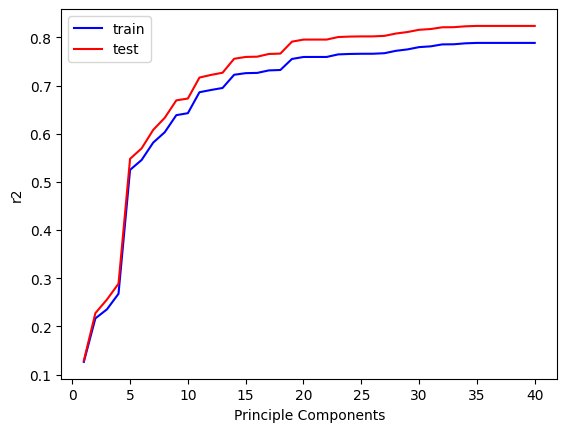

In [172]:
plt.plot(r2_table['Principle Components'], r2_table['train r2'], label='train', c='b')
plt.plot(r2_table['Principle Components'], r2_table['test r2'], label='test', c='r')
plt.xlabel('Principle Components')
plt.ylabel('r2')
plt.legend()
plt.show()

In [173]:
r2_table

,Principle Components,train r2,test r2
0,1,0.126191,0.128759
1,2,0.216636,0.227464
2,3,0.235389,0.255783
3,4,0.267818,0.288702
4,5,0.525047,0.547963
5,6,0.545654,0.569725
6,7,0.581653,0.608091
7,8,0.603254,0.633203
8,9,0.638668,0.669407
9,10,0.642783,0.673217


## Cross-Fold Validation

We choose 12 components to obtain $r^2\approx 0.7$.

In [174]:
pca.setNumComponents(12)

In [175]:
pca.principleDirections(Texture.train_attribute, centered=False)
reduced_input = pca.transform(Texture.train_attribute)

In [176]:
num_folds = 10
LR.setFolds(num_folds)
LR.crossFoldSplit(reduced_input, Texture.train_target)

In [177]:
train_accuracy, test_accuracy = LR.crossValidation(reduced_input, Texture.train_target)

In [178]:
train_accuracy

,SSTO,SSR,SSE,r2
Fold 1,57945.851316,39883.145522,18062.705794,0.688283
Fold 2,58311.698761,40320.270298,17991.428463,0.691461
Fold 3,58254.751936,40462.891922,17791.860014,0.694585
Fold 4,57805.221735,40113.765288,17691.456447,0.693947
Fold 5,58013.975478,40154.122353,17859.853125,0.692146
Fold 6,58275.674755,40125.838057,18149.836697,0.688552
Fold 7,58481.815178,40360.257245,18121.557933,0.690133
Fold 8,58081.901910,40154.721978,17927.179932,0.691347
Fold 9,58094.328601,40154.861421,17939.467180,0.691201
Fold 10,57823.219897,39849.249879,17973.970018,0.689157


In [179]:
test_accuracy

,SSTO,SSR,SSE,r2
Fold 1,6619.311628,4799.311053,1820.000575,0.725047
Fold 2,6246.346512,4331.513213,1914.833298,0.693447
Fold 3,6311.974419,4209.287213,2102.687206,0.666873
Fold 4,6740.886047,4514.754575,2226.131471,0.669757
Fold 5,6546.467442,4513.074638,2033.392804,0.689391
Fold 6,6198.046512,4462.139748,1735.906764,0.719927
Fold 7,6068.362791,4301.959613,1766.403177,0.708916
Fold 8,6438.986047,4599.080511,1839.905536,0.714255
Fold 9,6464.346512,4527.547244,1936.799268,0.700387
Fold 10,6723.071429,4830.167093,1892.904336,0.718446


In [180]:
train_accuracy.mean()

SSTO    58108.843957
SSR     40157.912396
SSE     17950.931560
r2          0.691081
dtype: float64

In [181]:
test_accuracy.mean()

SSTO    6435.779934
SSR     4508.883490
SSE     1926.896443
r2         0.700645
dtype: float64

# Decision Tree Classifier

In [182]:
pca.setNumComponents(39)

In [183]:
pca.principleDirections(Texture.train_attribute, centered=False)
reduced_input_train = pca.transform(Texture.train_attribute)

In [184]:
DT_Classifier = tree.DecisionTreeClassifier()
DT_Classifier.fit(reduced_input_train, Texture.train_target)

DecisionTreeClassifier()

In [185]:
#reduce the test data to be feed to the DT_Classifier
pca.principleDirections(Texture.test_attribute, centered=False)
reduced_input_test = pca.transform(Texture.test_attribute)

In [186]:
target_prediction_DT = pd.DataFrame(DT_Classifier.predict(reduced_input_test), columns=['A41'])

In [187]:
#calculates the total number of correct predictions and accuracy of the model
def calculateMetrics(test, prediction):
  total_correct_prediction = (target_prediction_DT == Texture.test_target).sum().iloc[0]
  #calculat the accuracy of the prediction
  accuracy = 100*(total_correct_prediction/len(test))
  return total_correct_prediction, accuracy

In [188]:
total_correct_prediction, accuracy = calculateMetrics(Texture.test_target, target_prediction_DT)

In [189]:
print("Out of " + str(len(Texture.test_target)) + ", " + str(total_correct_prediction) + " were correctly predicted.")
print("The accuracy achieved by the Decision Tree model is about " + str(round(accuracy)) +"%.")

Out of 1100, 124 were correctly predicted.
The accuracy achieved by the Decision Tree model is about 11%.


# Random Forest Classifier

In [190]:
pca.setNumComponents(12)

In [191]:
pca.principleDirections(Texture.train_attribute, centered=False)
reduced_input_train = pca.transform(Texture.train_attribute)

In [192]:
RF_classifier = ensemble.RandomForestClassifier()
RF_classifier.fit(reduced_input_train, Texture.train_target.to_numpy().ravel())

RandomForestClassifier()

In [193]:
#reduce the test data to be feed to the DT_Classifier
pca.principleDirections(Texture.test_attribute, centered=False)
reduced_input_test = pca.transform(Texture.test_attribute)

In [194]:
target_prediction_RF = pd.DataFrame(RF_classifier.predict(reduced_input_test), columns=['A41'])

In [195]:
total_correct_prediction_RF, accuracy_RF = calculateMetrics(Texture.test_target, target_prediction_RF)

In [196]:
print("Out of " + str(len(Texture.test_target)) + ", " + str(total_correct_prediction) + " were correctly predicted.")
print("The accuracy achieved by the Decision Tree model is about " + str(round(accuracy)) +"%.")

Out of 1100, 124 were correctly predicted.
The accuracy achieved by the Decision Tree model is about 11%.


In [197]:
"""calculate the oob score for the model for different number of trees"""
#minimum and maximum number of trees in the forest
min_estimator = 5
max_estimator = 150
estimator_range = np.arange(min_estimator, max_estimator+1, 5)

error = np.zeros(shape=(len(estimator_range), 2))

#set the oob_score to true
RF_classifier = ensemble.RandomForestClassifier(warm_start=True, oob_score=True)
raveled_target = Texture.train_target.to_numpy().ravel()

for i, x in enumerate(estimator_range):
  RF_classifier.set_params(n_estimators=x)
  RF_classifier.fit(reduced_input_train, raveled_target)
  error[i,0] = x
  error[i,1] = (1 - RF_classifier.oob_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


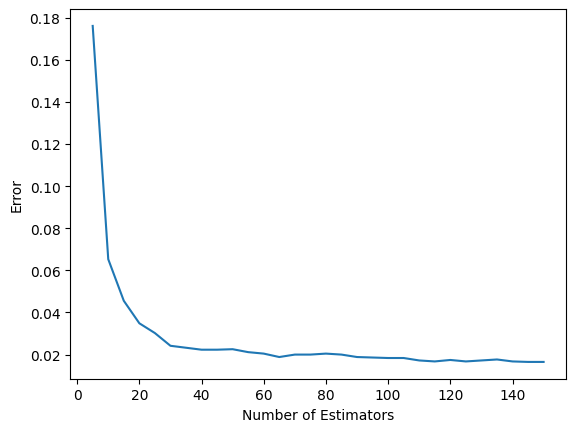

In [198]:
plt.plot(error[:,0], error[:,1])
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.show()

In [199]:
pca.setNumComponents(12)

In [200]:
normalized_attribute = Texture.normalize(Texture.train_attribute)

In [202]:
pca.principleDirections(normalized_attribute, centered=True)
reduced_input = pca.transform(normalized_attribute)

In [203]:
LR = linearRegression()
LR.fit(reduced_input, Texture.train_target)

In [204]:
prediction_accuracy, VIF = LR.modelAccuracy(reduced_input, Texture.train_target, vif_score=True)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [205]:
prediction_accuracy

SSTO    64567.976766
SSR     43706.736639
SSE     20861.240126
r2          0.676910
dtype: float64

In [ ]:
pca.setNumComponents(12)

In [206]:
pca.principleDirections(normalized_attribute, centered=False)
reduced_input = pca.transform(normalized_attribute)

In [207]:
num_folds = 10
LR.setFolds(num_folds)
LR.crossFoldSplit(reduced_input, Texture.train_target)

In [208]:
train_accuracy, test_accuracy = LR.crossValidation(reduced_input, Texture.train_target)

In [209]:
train_accuracy

,SSTO,SSR,SSE,r2
Fold 1,57945.851316,39042.032501,18903.818815,0.673768
Fold 2,58311.698761,39500.343454,18811.355307,0.677400
Fold 3,58254.751936,39637.872316,18616.879620,0.680423
Fold 4,57805.221735,39287.683832,18517.537902,0.679656
Fold 5,58013.975478,39312.836043,18701.139435,0.677644
Fold 6,58275.674755,39280.559768,18995.114987,0.674047
Fold 7,58481.815178,39606.998246,18874.816932,0.677253
Fold 8,58081.901910,39366.016281,18715.885629,0.677767
Fold 9,58094.328601,39340.800227,18753.528373,0.677188
Fold 10,57823.219897,39042.000081,18781.219816,0.675196
